\begin{center} 
Chun-Yuan (Scott) Chiu 
\end{center}

\begin{center} 
chunyuac@andrew.cmu.edu 
\end{center} 

# 1. {-}

## (a) {-}

In [1]:
# contents of problem1.py

import numpy as np

def get_data(n):
#     np.random.seed(0)               # fix seed
    x = np.random.uniform(size=n)
    y = x**2-x/2.0 + np.random.normal(size=n,scale=0.1)
    idx = np.argsort(x)
    return(x[idx].reshape((-1,1)),y[idx].reshape((-1,1)))

def true_mean(x):
    return(x**2-x/2.0)


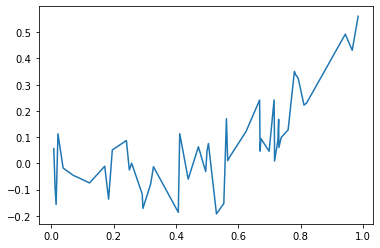

In [2]:
import matplotlib.pyplot as plt

X_train, y_train = get_data(50)
plt.plot(X_train, y_train)
plt.show()

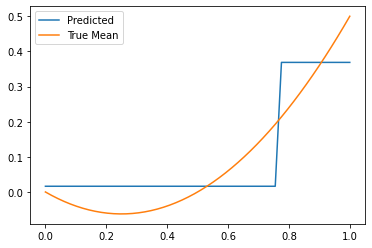

In [3]:
from sklearn.tree import DecisionTreeRegressor
from pandas import DataFrame

tree = DecisionTreeRegressor(max_depth=1).fit(X_train, y_train)
xgrid = np.array(np.linspace(0, 1, num=50)).reshape(50, 1)
df = DataFrame({'Predicted': tree.predict(xgrid), 'True Mean': true_mean(xgrid).flatten()}, index=xgrid.flatten())
df.plot()
plt.show()

## (b) {-}

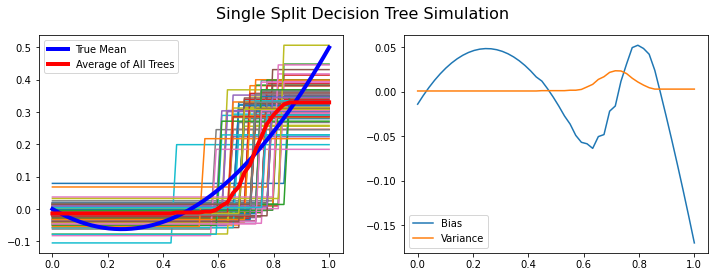

In [56]:
def tree1d(suptitle, n_sim=100, **DTkwarg):
    xgrid = np.array(np.linspace(0, 1, num=50)).reshape(50, 1)
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    fig.suptitle(suptitle, fontsize=16)
    
    pred = []
    for i in range(n_sim):
        X_train, y_train = get_data(50)
        tree = DecisionTreeRegressor(**DTkwarg).fit(X_train, y_train)
        pred_this_run = tree.predict(xgrid)
        pred.append(pred_this_run)
        ax1.plot(xgrid, pred_this_run, label=None)

    pred = np.array(pred)
    pred_mean = pred.mean(axis=0)
    true = true_mean(xgrid).flatten()

    ax1.plot(xgrid, true, 'b', linewidth=4, label='True Mean')
    ax1.plot(xgrid, pred_mean, 'r', linewidth=4, label='Average of All Trees')
    ax1.legend()

    ax2.plot(xgrid, pred_mean - true, label='Bias')
    ax2.plot(xgrid, pred.var(axis=0), label='Variance')
    ax2.legend()

    plt.show()
    
tree1d(suptitle='Single Split Decision Tree Simulation', max_depth=1)

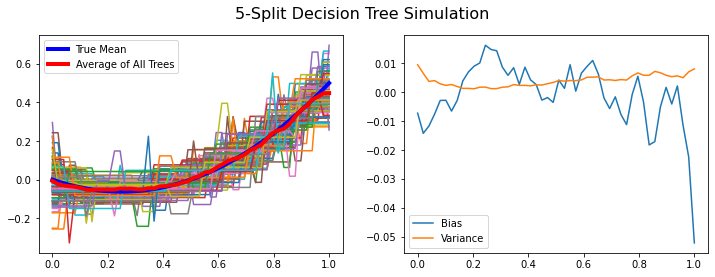

In [55]:
tree1d(suptitle='5-Split Decision Tree Simulation', max_leaf_nodes=6)

# 2. {-}

## (a) {-}

In [1]:
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np

X = pd.read_csv('marketing.csv')
X = pd.get_dummies(X, columns=['job', 'marital', 'education', 'default', 'housing', 'loan'])
y = np.where(X.pop('y')=='yes', 1, 0)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=1)
y_train.sum()/len(y_train)

0.11782377603908752

## (b) {-}

Here we train a logistic regression model, serialize the trained model and save it locally to prevent retraining. 

In [3]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import pickle, lzma

lr = LogisticRegression(penalty='none')
rf = RandomForestClassifier(oob_score=True)
rfimb = RandomForestClassifier(oob_score=True, min_samples_leaf=10)

for i, clf in enumerate([lr, rf, rfimb]):
    fitted = clf.fit(X_train, y_train)
    # https://stackoverflow.com/questions/57983431/whats-the-most-space-efficient-way-to-compress-serialized-python-data
    with lzma.open(f'clf{i}.xz', 'wb') as f:
        f.write(pickle.dumps(fitted))


In [6]:
import lzma, pickle

with lzma.open('clf0.xz', 'rb') as f:
    lr = pickle.loads(f.read())

with lzma.open('clf1.xz', 'rb') as f:
    rf = pickle.loads(f.read())    

with lzma.open('clf2.xz', 'rb') as f:
    rfimb = pickle.loads(f.read())    

    
lr, rf, rfimb

(LogisticRegression(penalty='none'),
 RandomForestClassifier(oob_score=True),
 RandomForestClassifier(min_samples_leaf=10, oob_score=True))

The misclassification rate calculated below is 11.55%. 

In [2]:
from sklearn.metrics import accuracy_score
import pickle

with open('clf.pkl', 'rb') as f:
    clf = pickle.load(f)
    
y_pred = clf.predict(X_test)
1 - accuracy_score(y_test, y_pred)

0.11548257372654158

## (c) {-}

A classifier to always say 'no' will have misclassification rate 11.53%, not much different from that of the logistic regression. 

In [3]:
y_pred = np.zeros_like(y_test)
1 - accuracy_score(y_test, y_pred)

0.11528150134048254

## (d) {-}

Only 11.53% out of all clients in the test data said yes. This is the sample proportion, also the MLE estimate of the fraction. If we randomly picked 1000 client to call, this is the fraction we can expect to say 'yes'. 

Selecting the first 1000 clients who have the largest probabilities to say 'yes' according to the logistic regression, the fraction increases to 29.1% (more than doubled). 

In [4]:
predict_proba_test = clf.predict_proba(X_test)[:, 1]
bestIdxSet = predict_proba_test.argsort()[-1000:]

y_select = y_test[bestIdxSet]

print('Fraction of clients who say yes from random selection: ', y_test.sum()/len(y_test))
print('Fraction of clients who say yes from logistic regression: ', y_select.sum()/len(y_select))

Fraction of clients who say yes from random selection:  0.11528150134048257
Fraction of clients who say yes from logistic regression:  0.291


## (e) {-}

Below is a the ROC curve plot and a convenient ```plot_roc``` function for later reuse. 

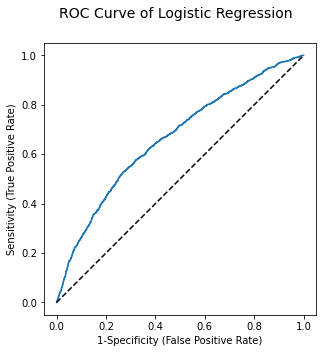

In [5]:
import matplotlib.pyplot as plt
from matplotlib import cm
from sklearn.metrics import roc_curve
from pandas import DataFrame

fpr, tpr, _ = roc_curve(y_test, predict_proba_test) 

def plot_roc(spec, sens):
    fig, ax = plt.subplots(1, 1, figsize=(5, 5))
    fig.suptitle('ROC Curve of Logistic Regression', fontsize=14)
    ax.plot(1-spec, sens)
    ax.plot([0, 1], [0, 1], 'k--')
    ax.set( aspect=1, 
            xlabel='1-Specificity (False Positive Rate)', 
            ylabel='Sensitivity (True Positive Rate)')
    return ax
    
plot_roc(1-fpr, tpr)
plt.show()